In [234]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch.optim as optim
import torch.nn as nn

df = pd.read_pickle('final-locs.pkl')

In [235]:
sub = df[['full_sea', 'lat, long', 'timestamp']]
sub.set_index('timestamp')

df_new = {}
for i in sub['lat, long'].unique():
    df_new[i] = {}
    df_new[i]["Train"], df_new[i]["Test"] = sub[sub['lat, long'] == i].iloc[:int(len(sub[sub['lat, long'] == i])*0.8)], sub[sub['lat, long'] == i].iloc[int(len(sub[sub['lat, long'] == i])*0.8):]

In [236]:
for i in df_new:
    print(df_new[i])

{'Train':        full_sea    lat, long  timestamp
2      2.375000  46.4, -48.4 2015-01-01
6      2.100000  46.4, -48.4 2015-01-02
10     2.871429  46.4, -48.4 2015-01-03
14     1.785714  46.4, -48.4 2015-01-04
18     2.462500  46.4, -48.4 2015-01-05
...         ...          ...        ...
1150  10.514286  46.4, -48.4 2015-10-15
1154  10.471429  46.4, -48.4 2015-10-16
1158  10.371429  46.4, -48.4 2015-10-17
1162  10.100000  46.4, -48.4 2015-10-18
1166  10.137500  46.4, -48.4 2015-10-19

[292 rows x 3 columns], 'Test':        full_sea    lat, long  timestamp
1170   9.487500  46.4, -48.4 2015-10-20
1174   8.750000  46.4, -48.4 2015-10-21
1178   9.450000  46.4, -48.4 2015-10-22
1182  10.062500  46.4, -48.4 2015-10-23
1186   9.837500  46.4, -48.4 2015-10-24
...         ...          ...        ...
1442   0.814286  46.4, -48.4 2015-12-27
1446   0.587500  46.4, -48.4 2015-12-28
1450   0.500000  46.4, -48.4 2015-12-29
1454   0.475000  46.4, -48.4 2015-12-30
1458   0.712500  46.4, -48.4 2015-12-

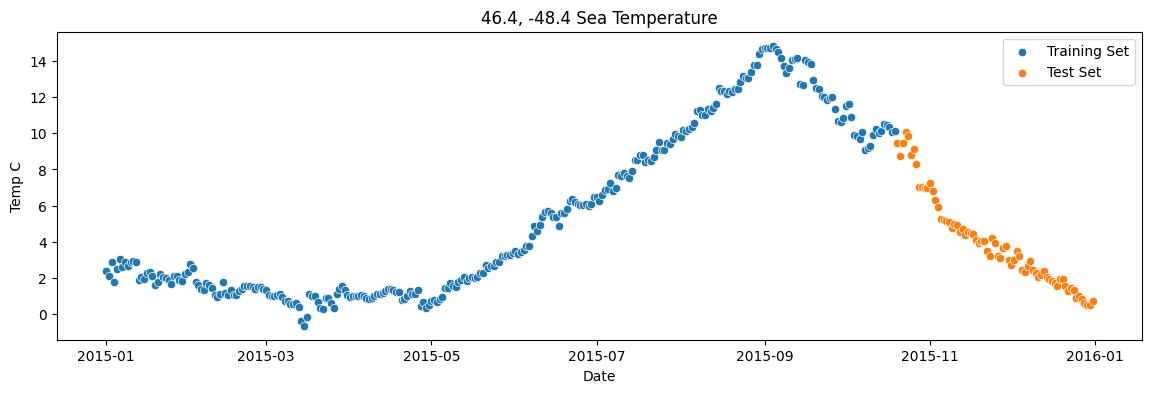

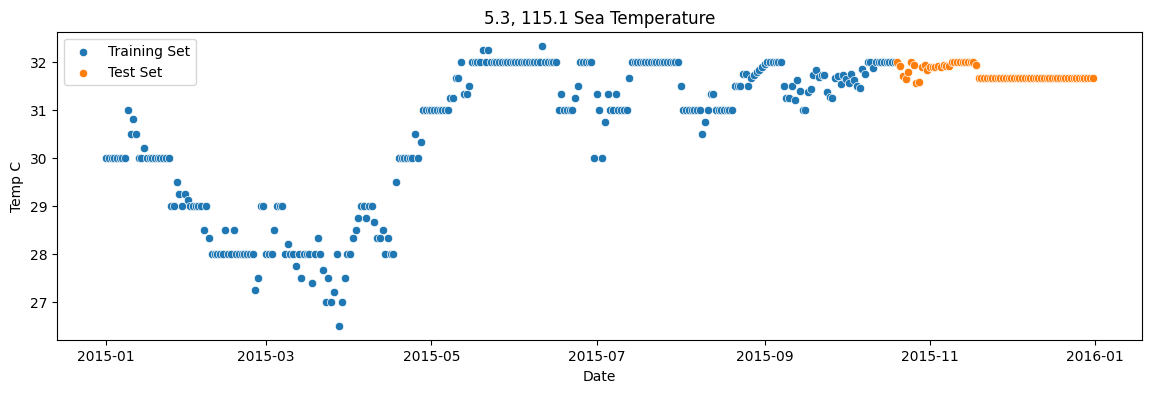

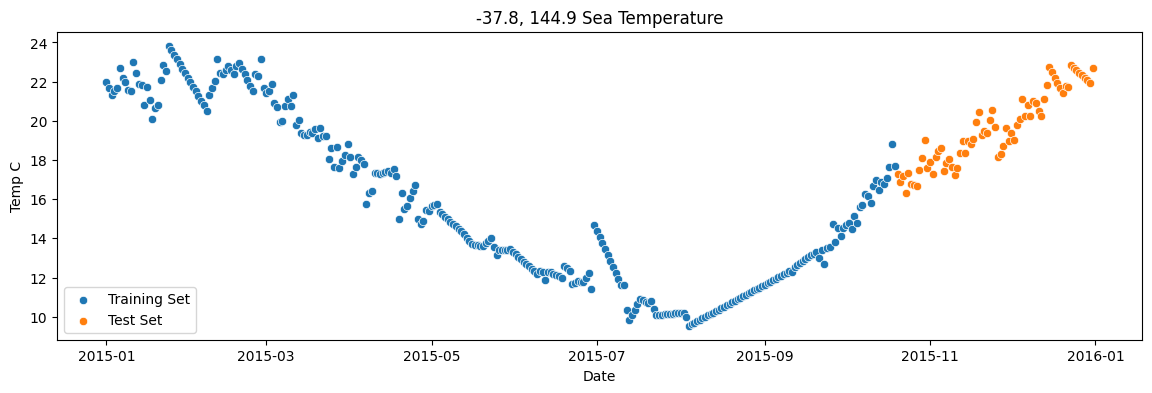

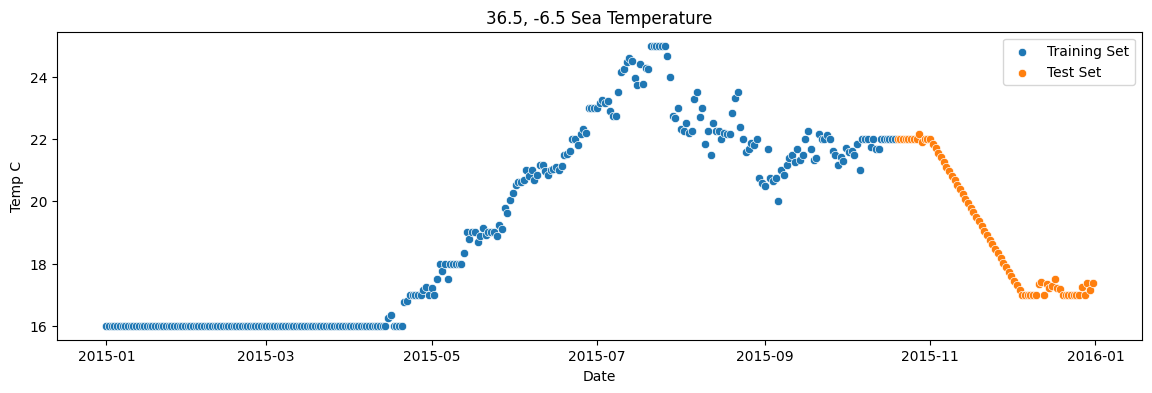

In [237]:
import seaborn as sns

for i in df['lat, long'].unique():
    plt.figure(figsize=(14,4))
    sns.scatterplot(y=df_new[i]["Train"]['full_sea'], x=df_new[i]['Train']['timestamp'])
    sns.scatterplot(y=df_new[i]["Test"]['full_sea'], x=df_new[i]['Test']['timestamp'])
    plt.ylabel("Temp C")
    plt.xlabel("Date")
    plt.legend(["Training Set", "Test Set"])
    plt.title(i + " Sea Temperature")

In [238]:
from sklearn.preprocessing import MinMaxScaler

transform_train = {}
transform_test = {}
scaler = {}

for num, i in enumerate(df['lat, long'].unique()):
    sc = MinMaxScaler(feature_range=(0,1))
    a0 = np.array(df_new[i]["Train"]['full_sea'])
    a1 = np.array(df_new[i]["Test"]['full_sea'])
    a0 = a0.reshape(a0.shape[0],1)
    a1 = a1.reshape(a1.shape[0],1)
    transform_train[i] = sc.fit_transform(a0)
    transform_test[i] = sc.fit_transform(a1)
    scaler[i] = sc
    
del a0
del a1

In [239]:
for i in transform_train.keys():
    print(i, transform_train[i].shape)

print("\n")   

for i in transform_test.keys():
    print(i, transform_test[i].shape)

46.4, -48.4 (292, 1)
5.3, 115.1 (292, 1)
-37.8, 144.9 (292, 1)
36.5, -6.5 (292, 1)


46.4, -48.4 (73, 1)
5.3, 115.1 (73, 1)
-37.8, 144.9 (73, 1)
36.5, -6.5 (73, 1)


In [240]:
def dataload(seq):
    trainset = {}
    testset = {}

    for j in df['lat, long'].unique():
        trainset[j] = {}
        X_train = []
        y_train = []
        
        for i in range(seq, 292):
            X_train.append(transform_train[j][i-seq:i,0])
            y_train.append(transform_train[j][i,0])
        
        X_train, y_train = np.array(X_train), np.array(y_train)
        trainset[j]["X"] = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
        trainset[j]["y"] = y_train
        
        testset[j] = {}
        X_test = []
        y_test = []    
        
        for i in range(seq, 73):
            X_test.append(transform_test[j][i-seq:i,0])
            y_test.append(transform_test[j][i,0])
        
        X_test, y_test = np.array(X_test), np.array(y_test)
        testset[j]["X"] = np.reshape(X_test, (X_test.shape[0], X_train.shape[1], 1))
        testset[j]["y"] = y_test

    return trainset, testset

In [241]:
trainset, testset = dataload(7)

In [242]:
arr_buff = []

for i in df['lat, long'].unique():
    buff = {}
    buff["X_train"] = trainset[i]["X"].shape
    buff["y_train"] = trainset[i]["y"].shape
    buff["X_test"] = testset[i]["X"].shape
    buff["y_test"] = testset[i]["y"].shape
    arr_buff.append(buff)

pd.DataFrame(arr_buff, index=df['lat, long'].unique())

,X_train,y_train,X_test,y_test
"46.4, -48.4","(285, 7, 1)","(285,)","(66, 7, 1)","(66,)"
"5.3, 115.1","(285, 7, 1)","(285,)","(66, 7, 1)","(66,)"
"-37.8, 144.9","(285, 7, 1)","(285,)","(66, 7, 1)","(66,)"
"36.5, -6.5","(285, 7, 1)","(285,)","(66, 7, 1)","(66,)"


In [299]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate RNN
        out, _ = self.rnn(x, h0)

        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

# Example usage:
# Define input parameters
input_size = 1  # Number of features in input data (e.g., time series)
hidden_size = 20  # Number of hidden units in the RNN
num_layers = 2  # Number of RNN layers
output_size = 1  # Number of features in output data (e.g., regression target)

# Instantiate the model
model = RNN(input_size, hidden_size, num_layers, output_size)

# Print model architecture
print(model)

RNN(
  (rnn): RNN(1, 20, num_layers=2, batch_first=True)
  (fc): Linear(in_features=20, out_features=1, bias=True)
)


In [300]:
rnn_preds = {}

# Define the loss function
criterion = nn.L1Loss()  # Mean Absolute Error (MAE) loss
# criterion = nn.MSELoss()  # Mean Squared Error (MSE) loss

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

for i in df['lat, long'].unique():
    # Convert numpy arrays to PyTorch tensors
    X_train = torch.tensor(trainset[i]["X"], dtype=torch.float32)
    y_train = torch.tensor(trainset[i]["y"], dtype=torch.float32)
    
    num_epochs = 500
    # Training loop
    for epoch in range(num_epochs):
        # Forward pass
        outputs = model(X_train)
        
        # Calculate loss
        loss = criterion(outputs, y_train.reshape(-1, 1))
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print(f'Epoch {epoch+1}, Loss: {loss.item()}')

    # Evaluation
    with torch.no_grad():
        model.eval()  # Set the model to evaluation mode
        outputs = model(X_train)
        
        # Reshape the target data to match the shape of the model's output
        y_train_reshaped = y_train.reshape(-1, 1)
        
        mae_loss = criterion(outputs, y_train_reshaped)
        print(f'\nMAE Loss on Training Set for {i}: {mae_loss.item():.4f}')
        rnn_preds[i] = scaler[i].inverse_transform(outputs.numpy())

        # Calculate training accuracy
   
    train_accuracy = torch.mean(torch.abs(outputs - y_train)).item()

    # Evaluate on test set
    X_test = torch.tensor(testset[i]["X"], dtype=torch.float32)
    y_test = torch.tensor(testset[i]["y"], dtype=torch.float32)
    with torch.no_grad():
        model.eval()  # Set the model to evaluation mode
        test_outputs = model(X_test)
        test_accuracy = torch.mean(torch.abs(test_outputs - y_test)).item()
        rnn_preds[i] = scaler[i].inverse_transform(test_outputs.numpy())

    # Print progress
    print(f'\nEpoch [{epoch+1}/{num_epochs}], Training MAE: {train_accuracy:.4f}, Test MAE: {test_accuracy:.4f}')

    model.train()  # Set the model back to training mode


Epoch 1, Loss: 0.5921260714530945
Epoch 2, Loss: 0.5502974390983582
Epoch 3, Loss: 0.5092002749443054
Epoch 4, Loss: 0.46879979968070984
Epoch 5, Loss: 0.4289192855358124
Epoch 6, Loss: 0.3893135190010071
Epoch 7, Loss: 0.3499877154827118
Epoch 8, Loss: 0.31111517548561096
Epoch 9, Loss: 0.27629223465919495
Epoch 10, Loss: 0.255968302488327
Epoch 11, Loss: 0.2461303174495697
Epoch 12, Loss: 0.24131307005882263
Epoch 13, Loss: 0.23928457498550415
Epoch 14, Loss: 0.23861916363239288
Epoch 15, Loss: 0.23787392675876617
Epoch 16, Loss: 0.23708279430866241
Epoch 17, Loss: 0.2362806349992752
Epoch 18, Loss: 0.23537075519561768
Epoch 19, Loss: 0.23447354137897491
Epoch 20, Loss: 0.2333046942949295
Epoch 21, Loss: 0.2315526008605957
Epoch 22, Loss: 0.22887343168258667
Epoch 23, Loss: 0.22525767982006073
Epoch 24, Loss: 0.22073303163051605
Epoch 25, Loss: 0.21539106965065002
Epoch 26, Loss: 0.20934492349624634
Epoch 27, Loss: 0.20269052684307098
Epoch 28, Loss: 0.19586974382400513
Epoch 29, Los

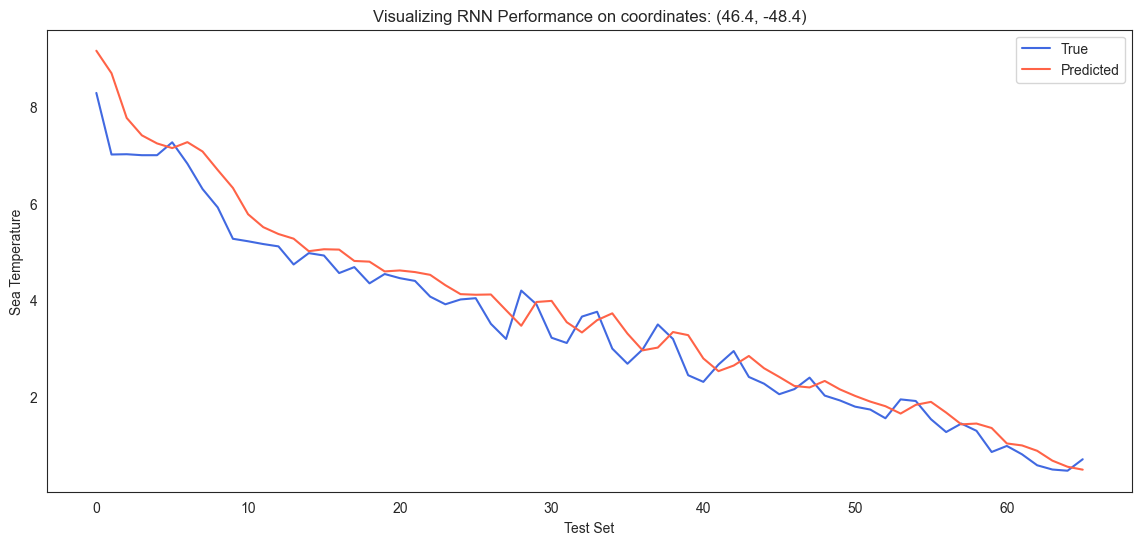

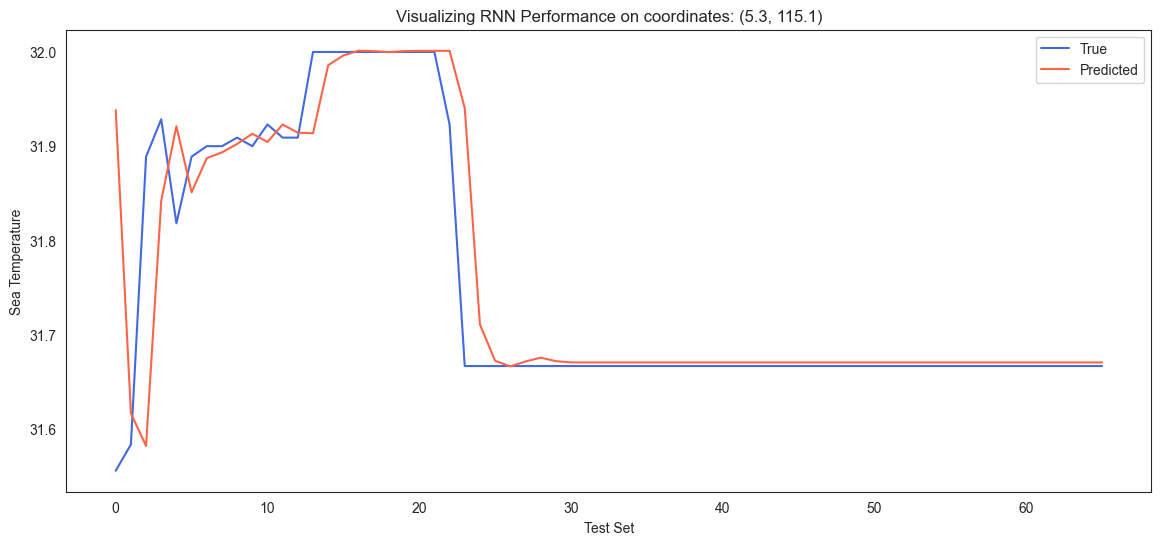

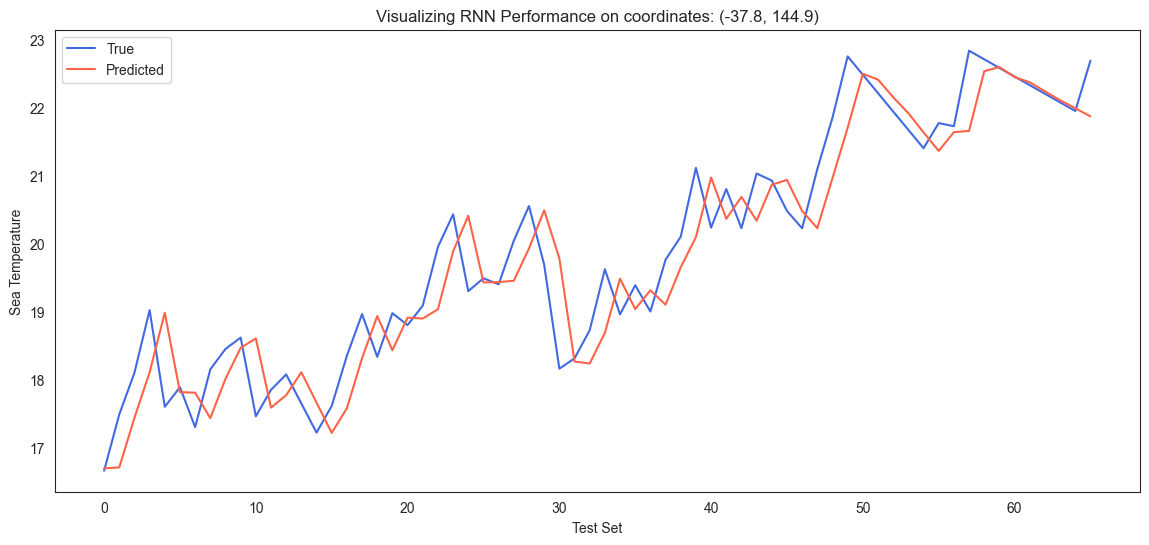

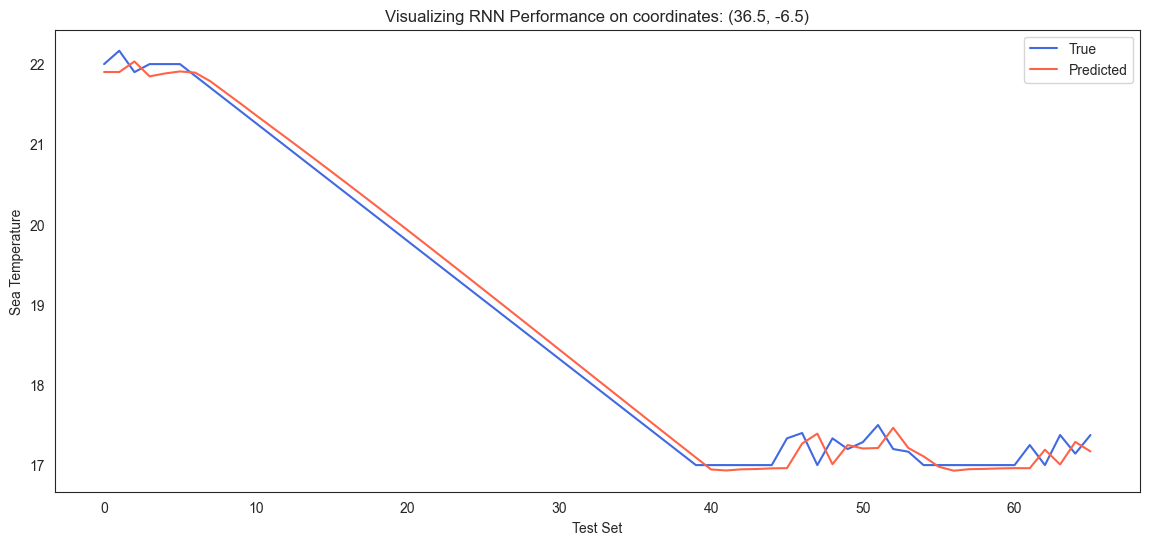

In [316]:
for i in df['lat, long'].unique():
    y_true = scaler[i].inverse_transform(testset[i]["y"].reshape(-1,1))
    y_pred = rnn_preds[i]
    
    plt.figure(figsize=(14,6))

    plt.xlabel('Test Set')
    plt.ylabel('Sea Temperature')
    plt.title(f'Visualizing RNN Performance on coordinates: ({i})')

    sns.lineplot(y_true.flatten(), color='royalblue', label='True')
    sns.lineplot(y_pred.flatten(), color='tomato', label='Predicted')
    plt.show()

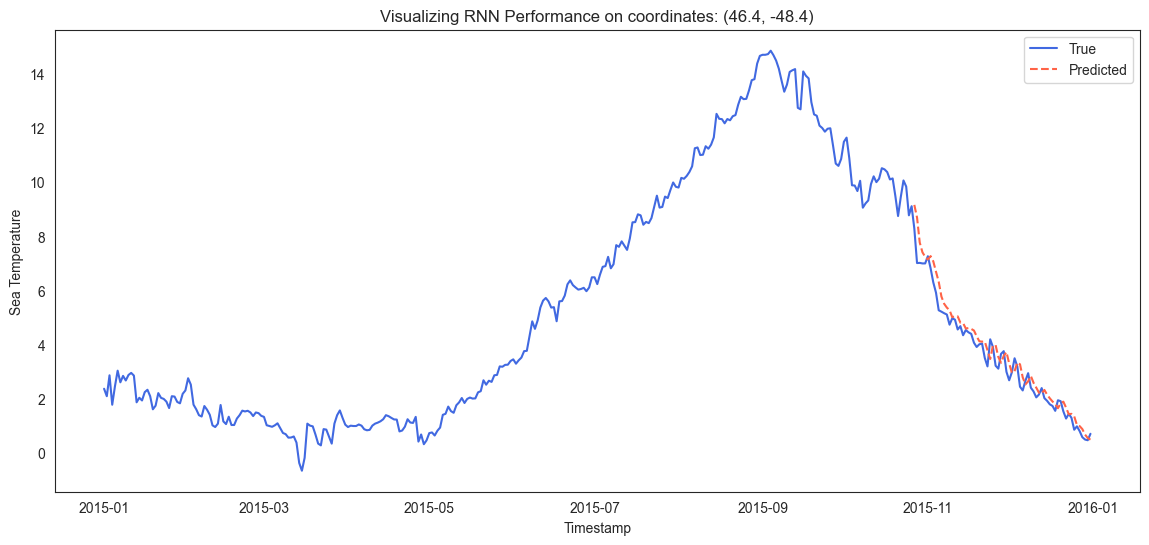

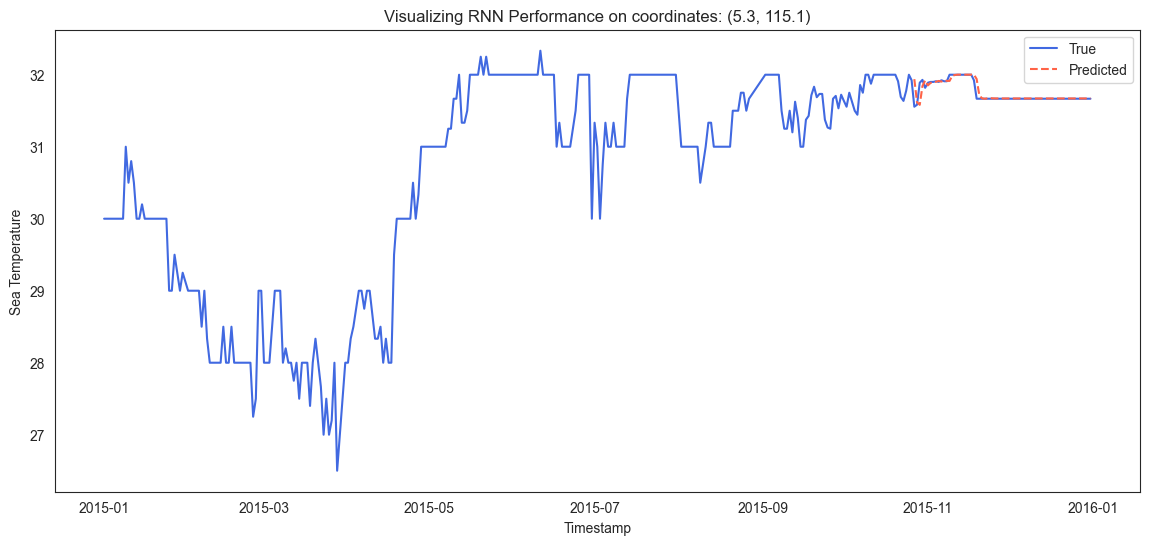

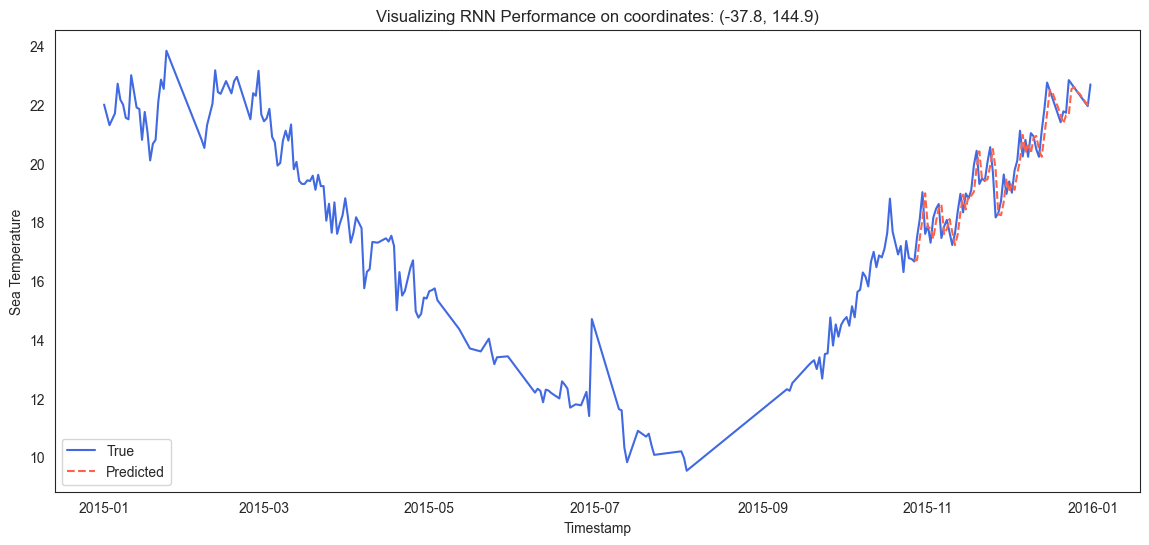

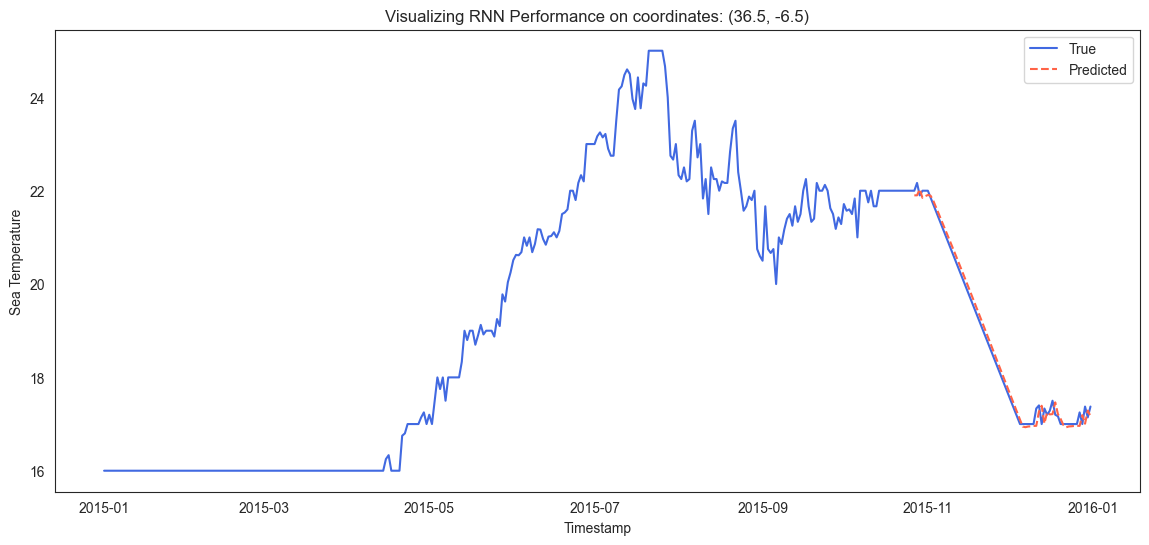

In [302]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("white")


# Define timestamp
timestamp = df['timestamp'].unique()

for i in df['lat, long'].unique():
    temps = rnn_preds[i].reshape(-1)
    adj = timestamp[365 - len(rnn_preds[i]):]
    temps = pd.DataFrame({'timestamp': adj, 'temps': temps})
    
    sub = df[df['lat, long'] == i]

    plt.figure(figsize=(14,6))
    
    # Plot true sea temperature
    sns.lineplot(data=sub, x='timestamp', y='full_sea', label='True', color='royalblue')
    
    # Plot predicted sea temperature
    sns.lineplot(data=temps, x='timestamp', y='temps', label='Predicted', color='tomato', linestyle='--')
    
    # Add labels and legend
    plt.xlabel('Timestamp')
    plt.ylabel('Sea Temperature')
    plt.title(f'Visualizing RNN Performance on coordinates: ({i})')
    plt.legend()
    
    # Show plot
    plt.show()


# LSTM

In [303]:
import torch.optim as optim
import torch.nn as nn

# Define the LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Example usage:
# Define input parameters
input_size = 1  # Number of features in input data (e.g., time series)
hidden_size = 20  # Number of hidden units in the LSTM
num_layers = 2  # Number of LSTM layers
output_size = 1  # Number of features in output data (e.g., regression target)

# Instantiate the model
model = LSTM(input_size, hidden_size, num_layers, output_size)

# Print model architecture
print(model)

LSTM(
  (lstm): LSTM(1, 20, num_layers=2, batch_first=True)
  (fc): Linear(in_features=20, out_features=1, bias=True)
)


In [306]:
lstm_preds = {}

# Define the loss function
criterion = nn.L1Loss()  # Mean Absolute Error (MAE) loss
# criterion = nn.MSELoss()  # Mean Squared Error (MSE) loss

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

for i in df['lat, long'].unique():
    # Convert numpy arrays to PyTorch tensors
    X_train = torch.tensor(trainset[i]["X"], dtype=torch.float32)
    y_train = torch.tensor(trainset[i]["y"], dtype=torch.float32)
    
    num_epochs = 500
    # Training loop
    for epoch in range(num_epochs):
        # Forward pass
        outputs = model(X_train)
        
        # Calculate loss
        loss = criterion(outputs, y_train.reshape(-1, 1))
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print(f'Epoch {epoch+1}, Loss: {loss.item()}')

    # Evaluation
    with torch.no_grad():
        model.eval()  # Set the model to evaluation mode
        outputs = model(X_train)
        
        # Reshape the target data to match the shape of the model's output
        y_train_reshaped = y_train.reshape(-1, 1)
        
        mae_loss = criterion(outputs, y_train_reshaped)
        print(f'\nMAE Loss on Training Set for {i}: {mae_loss.item():.4f}')
        lstm_preds[i] = scaler[i].inverse_transform(outputs.numpy())

        # Calculate training accuracy
   
    train_accuracy = torch.mean(torch.abs(outputs - y_train)).item()

    # Evaluate on test set
    X_test = torch.tensor(testset[i]["X"], dtype=torch.float32)
    y_test = torch.tensor(testset[i]["y"], dtype=torch.float32)
    with torch.no_grad():
        model.eval()  # Set the model to evaluation mode
        test_outputs = model(X_test)
        test_accuracy = torch.mean(torch.abs(test_outputs - y_test)).item()
        lstm_preds[i] = scaler[i].inverse_transform(test_outputs.numpy())

    # Print progress
    print(f'\nEpoch [{epoch+1}/{num_epochs}], Training MAE: {train_accuracy:.4f}, Test MAE: {test_accuracy:.4f}')

    model.train()  # Set the model back to training mode


Epoch 1, Loss: 0.016577936708927155
Epoch 2, Loss: 0.04742821305990219
Epoch 3, Loss: 0.018764881417155266
Epoch 4, Loss: 0.03342938423156738
Epoch 5, Loss: 0.03734724223613739
Epoch 6, Loss: 0.024799566715955734
Epoch 7, Loss: 0.016104845330119133
Epoch 8, Loss: 0.025258926674723625
Epoch 9, Loss: 0.028532426804304123
Epoch 10, Loss: 0.023264750838279724
Epoch 11, Loss: 0.016330063343048096
Epoch 12, Loss: 0.018499432131648064
Epoch 13, Loss: 0.02347649447619915
Epoch 14, Loss: 0.022789862006902695
Epoch 15, Loss: 0.018200429156422615
Epoch 16, Loss: 0.01610236056149006
Epoch 17, Loss: 0.018778789788484573
Epoch 18, Loss: 0.020713837817311287
Epoch 19, Loss: 0.018914643675088882
Epoch 20, Loss: 0.01611771248281002
Epoch 21, Loss: 0.016288530081510544
Epoch 22, Loss: 0.018372895196080208
Epoch 23, Loss: 0.018529396504163742
Epoch 24, Loss: 0.016617655754089355
Epoch 25, Loss: 0.015824178233742714
Epoch 26, Loss: 0.016950922086834908
Epoch 27, Loss: 0.01764497719705105
Epoch 28, Loss: 0

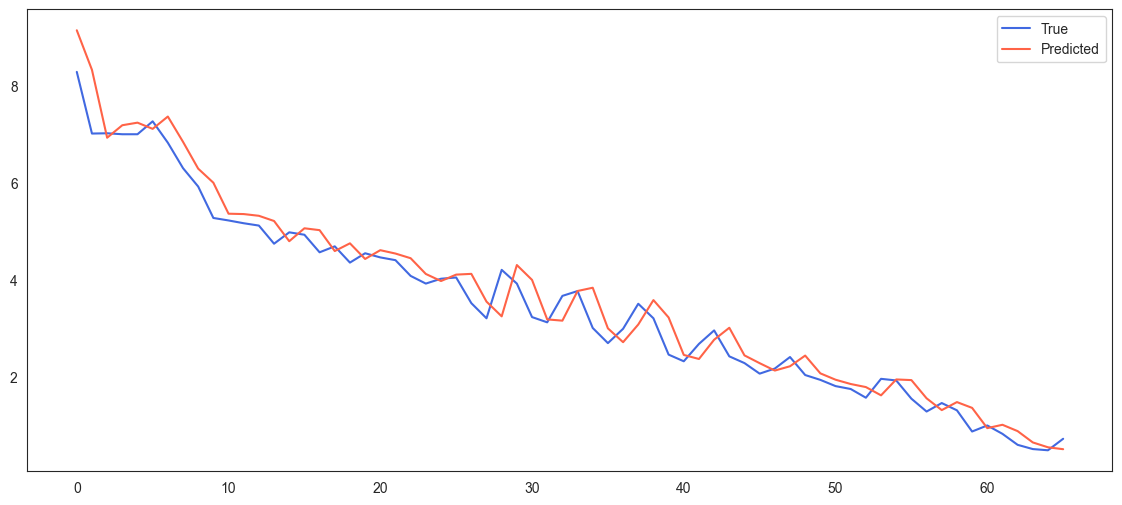

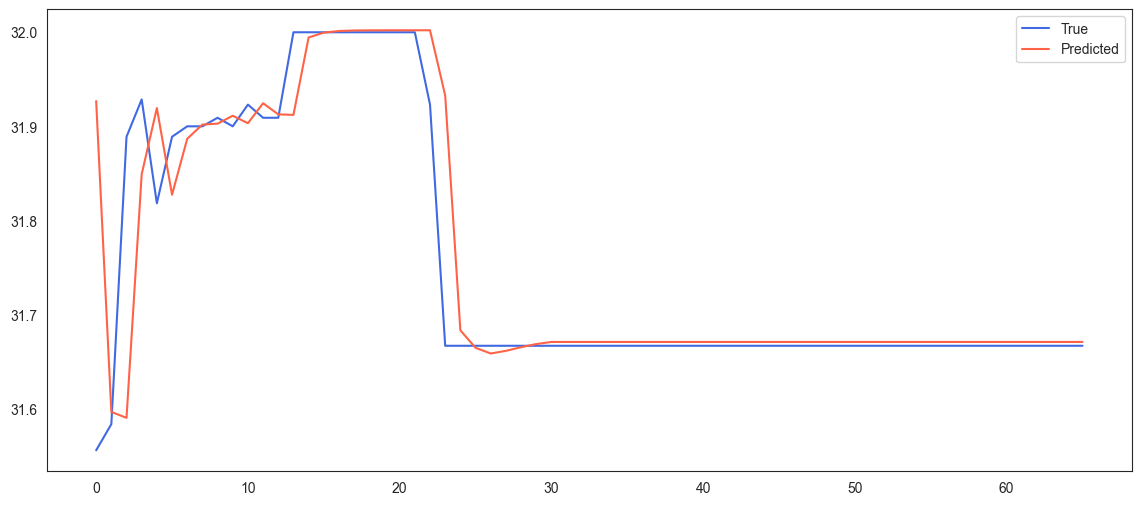

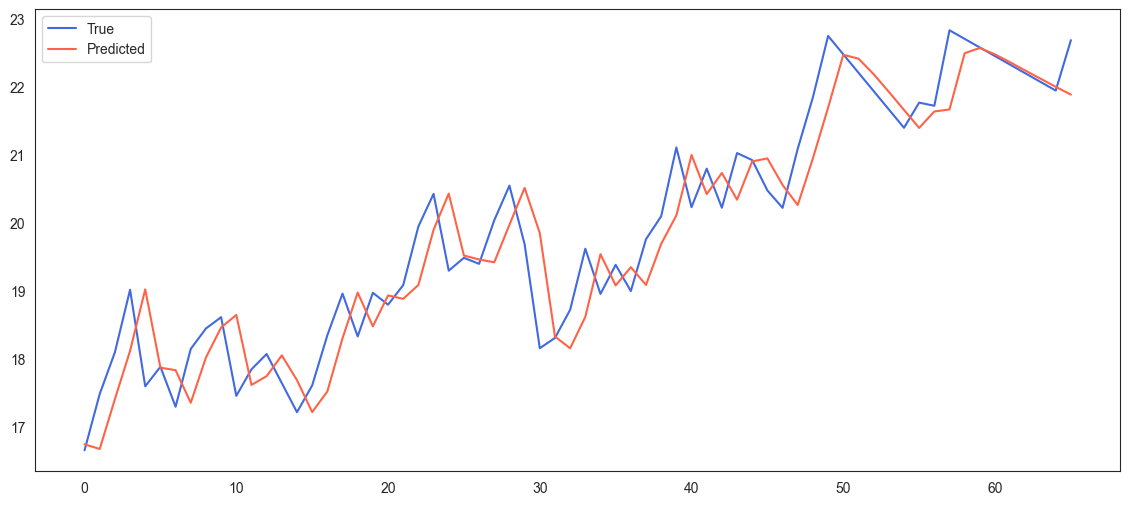

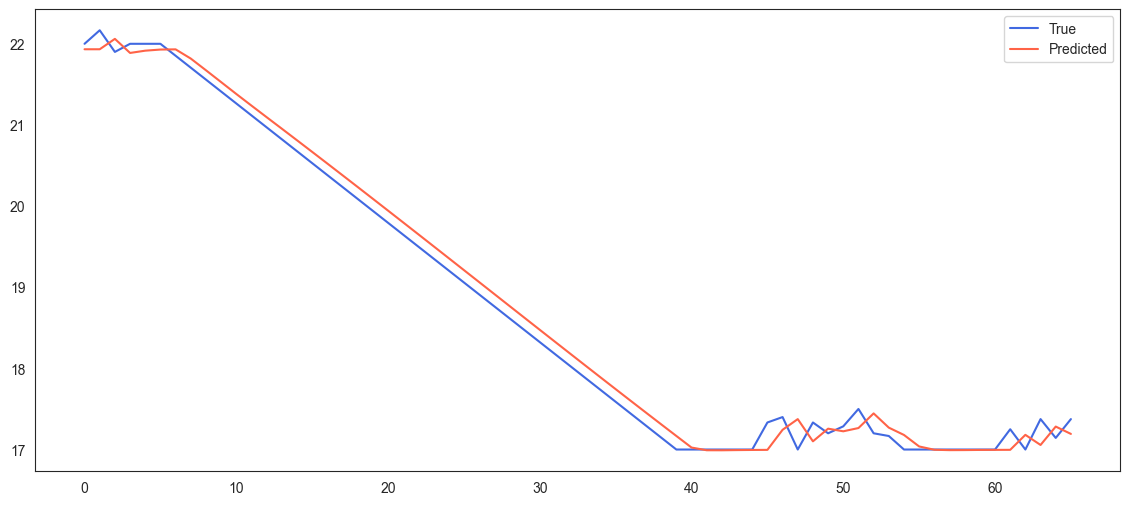

In [307]:
for i in df['lat, long'].unique():
    y_true = scaler[i].inverse_transform(testset[i]["y"].reshape(-1,1))
    y_pred = lstm_preds[i]
    
    plt.figure(figsize=(14,6))

    plt.xlabel('Test Set')
    plt.ylabel('Sea Temperature')
    plt.title(f'Visualizing LSTM Performance on coordinates: ({i})')

    sns.lineplot(y_true.flatten(), color='royalblue', label='True')
    sns.lineplot(y_pred.flatten(), color='tomato', label='Predicted')
    plt.show()

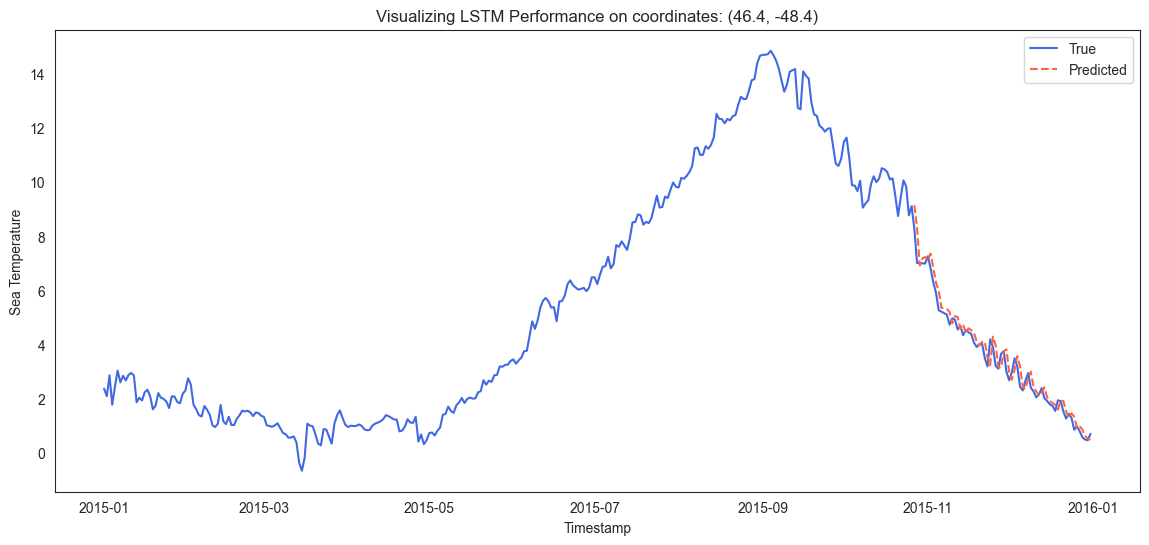

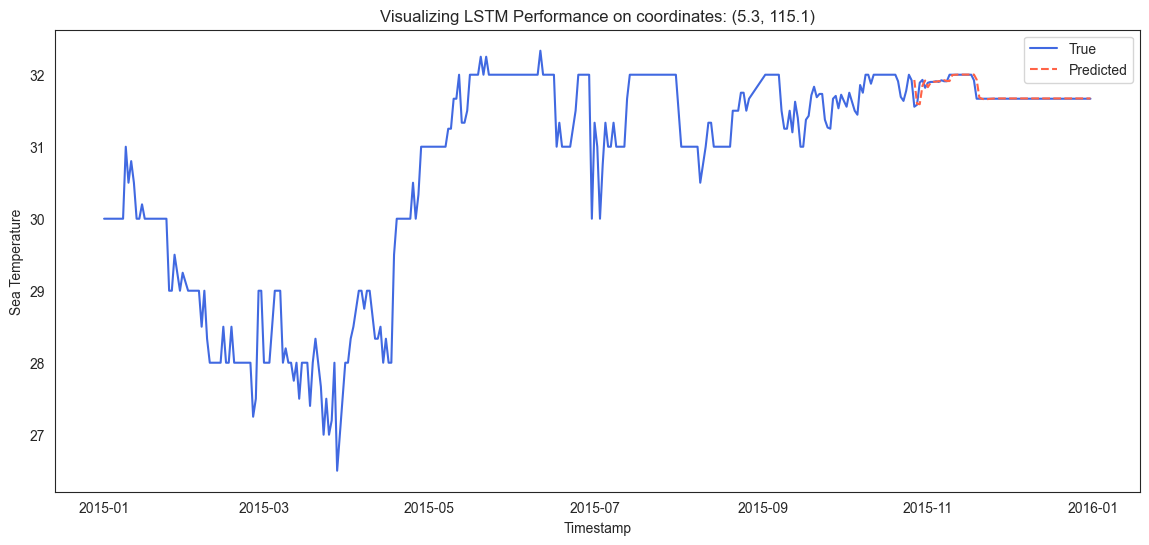

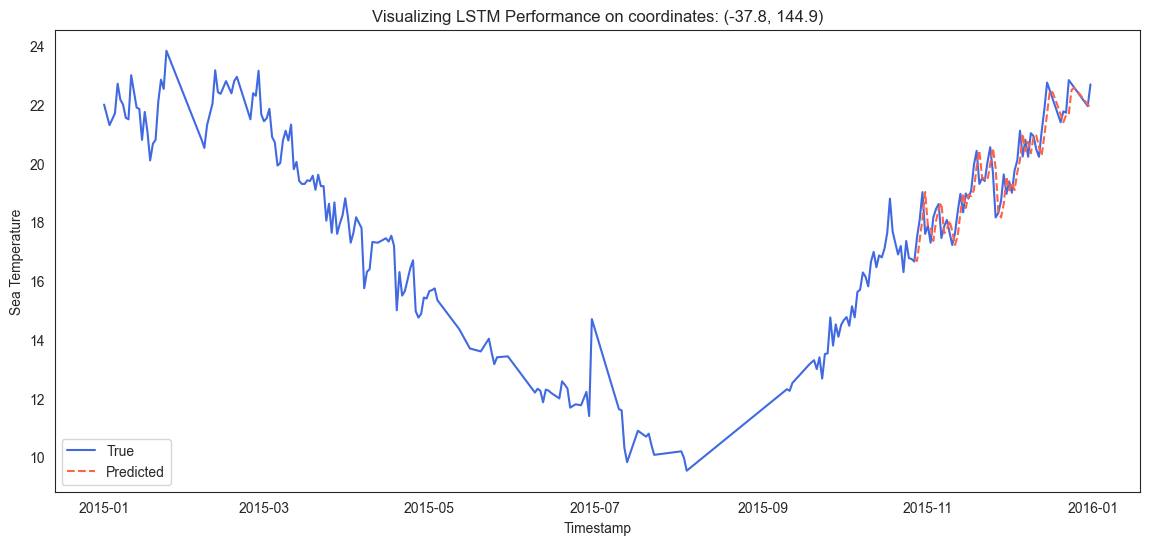

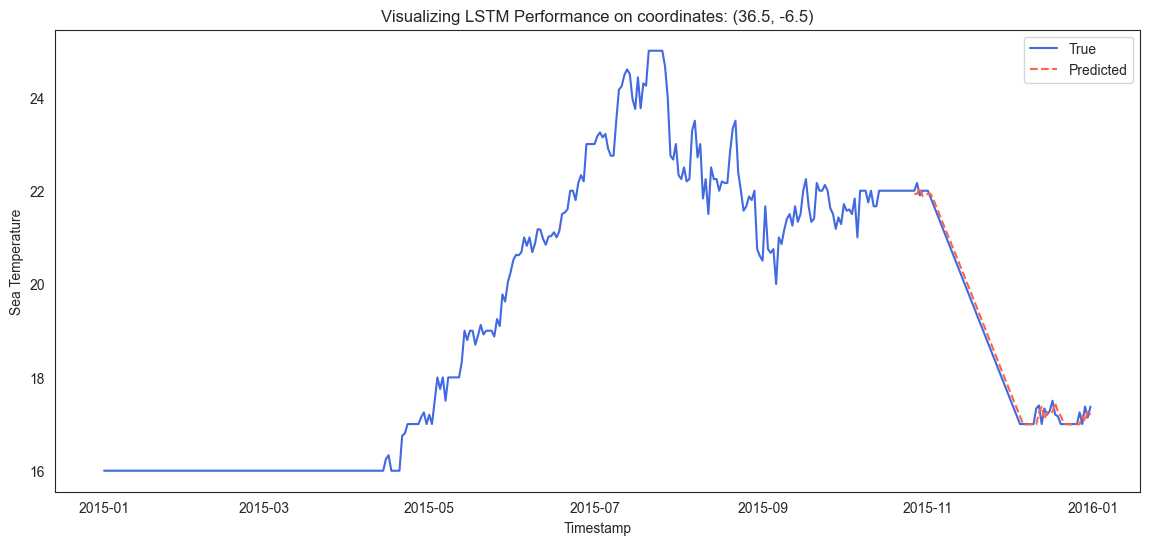

In [308]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("white")

# Define timestamp
timestamp = df['timestamp'].unique()

for i in df['lat, long'].unique():
    temps = lstm_preds[i].reshape(-1)
    adj = timestamp[365 - len(lstm_preds[i]):]
    temps = pd.DataFrame({'timestamp': adj, 'temps': temps})
    
    sub = df[df['lat, long'] == i]

    plt.figure(figsize=(14,6))
    
    # Plot true sea temperature
    sns.lineplot(data=sub, x='timestamp', y='full_sea', label='True', color='royalblue')
    
    # Plot predicted sea temperature
    sns.lineplot(data=temps, x='timestamp', y='temps', label='Predicted', color='tomato', linestyle='--')
    
    # Add labels and legend
    plt.xlabel('Timestamp')
    plt.ylabel('Sea Temperature')
    plt.title(f'Visualizing LSTM Performance on coordinates: ({i})')
    plt.legend()
    
    # Show plot
    plt.show()


# Comparing Models

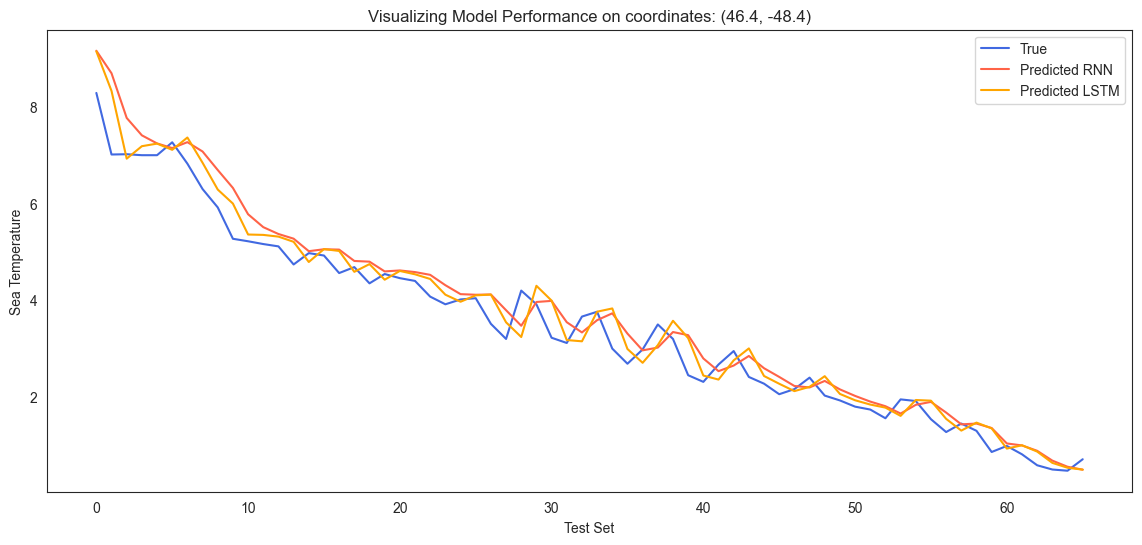

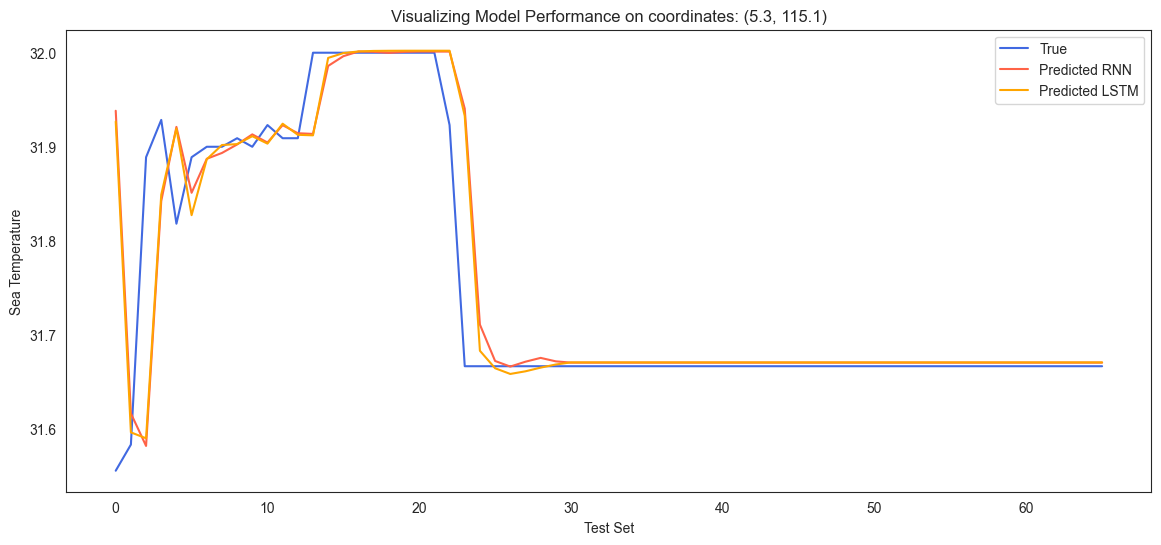

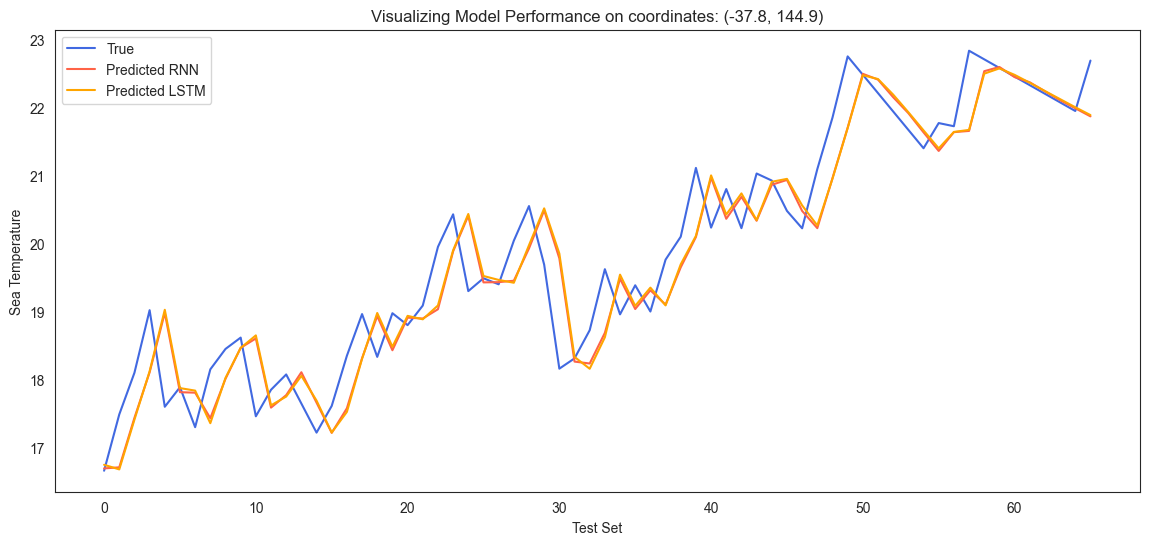

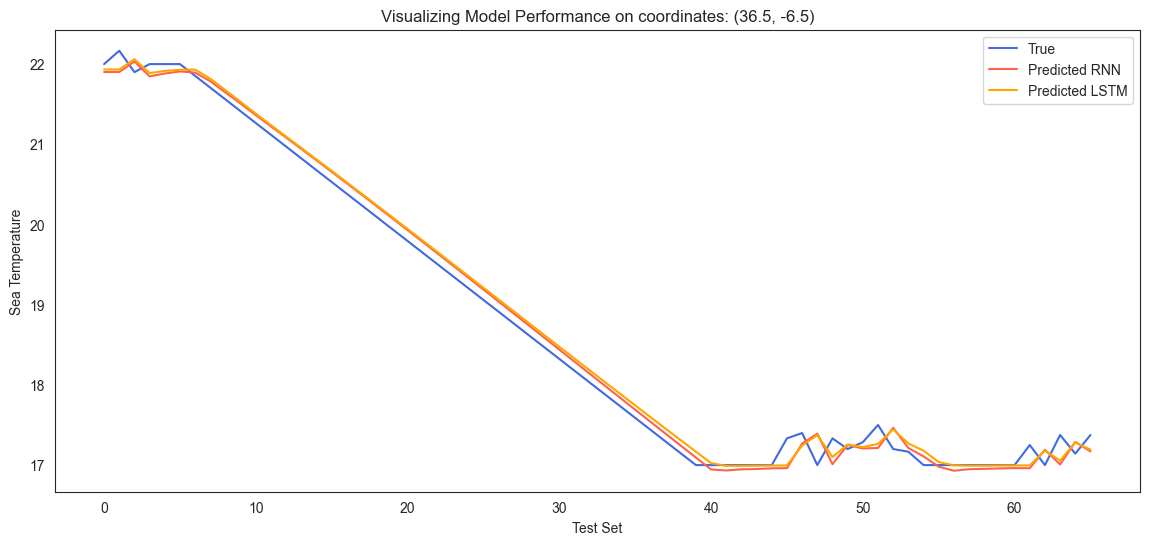

In [317]:
for i in df['lat, long'].unique():
    y_true = scaler[i].inverse_transform(testset[i]["y"].reshape(-1,1))
    y_pred_rnn = rnn_preds[i]
    y_pred_lstm = lstm_preds[i]
    
    plt.figure(figsize=(14,6))

    plt.xlabel('Test Set')
    plt.ylabel('Sea Temperature')
    plt.title(f'Visualizing Model Performance on coordinates: ({i})')

    sns.lineplot(y_true.flatten(), color='royalblue', label='True')
    sns.lineplot(y_pred_rnn.flatten(), color='tomato', label='Predicted RNN')
    sns.lineplot(y_pred_lstm.flatten(), color='orange', label='Predicted LSTM')
    plt.show()

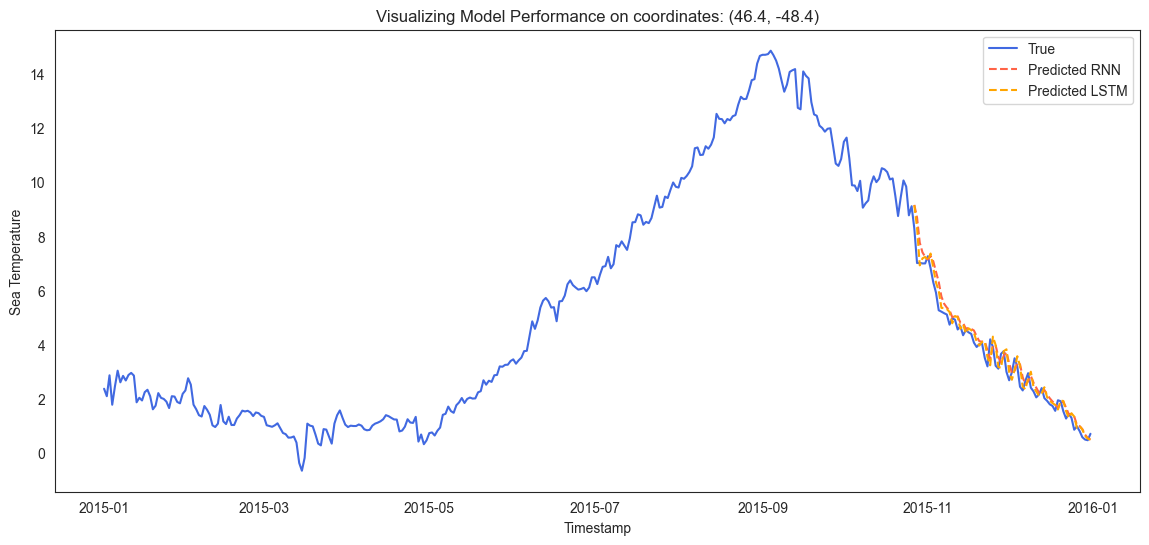

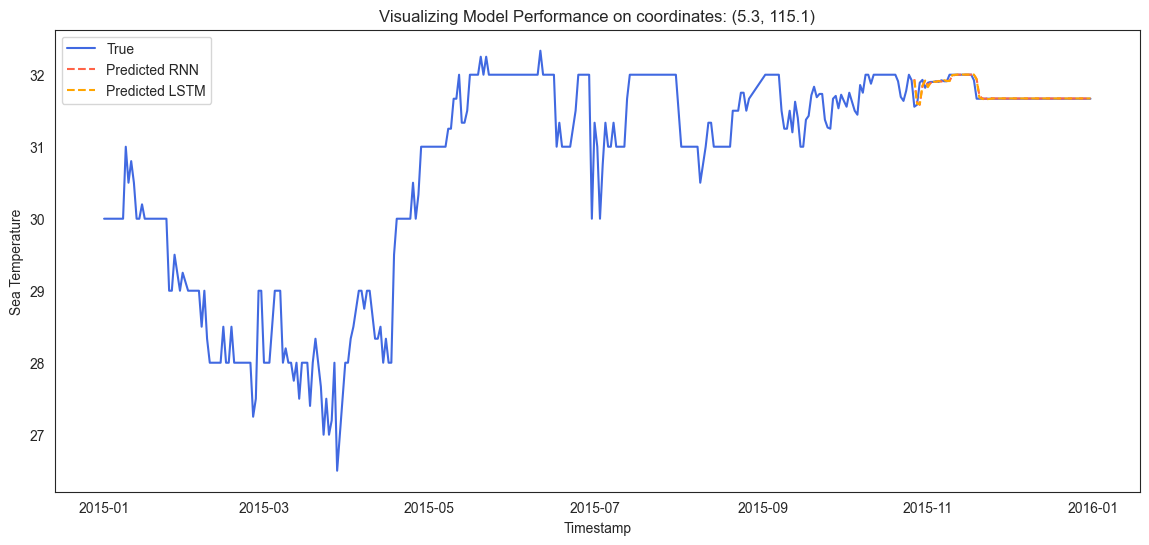

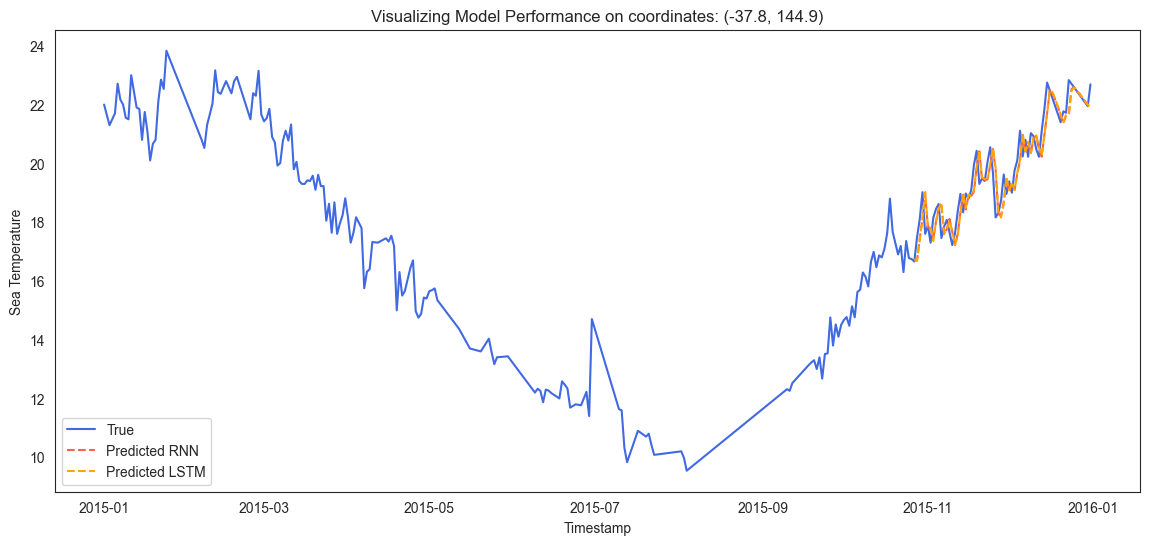

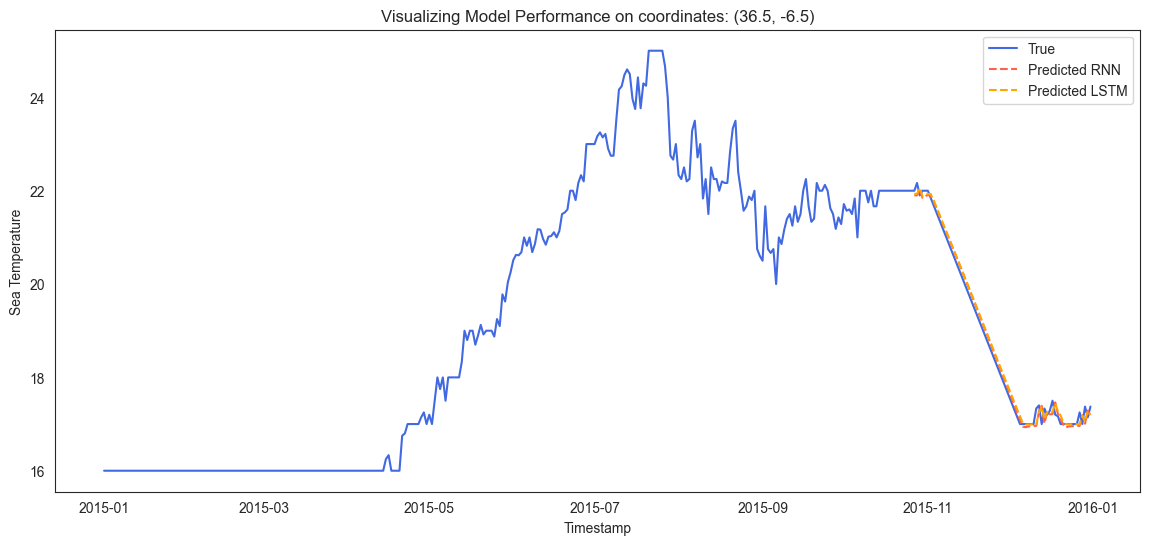

In [318]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("white")

# Define timestamp
timestamp = df['timestamp'].unique()

for i in df['lat, long'].unique():
    temps = rnn_preds[i].reshape(-1)
    adj = timestamp[365 - len(lstm_preds[i]):]
    
    temps_rnn = pd.DataFrame({'timestamp': adj, 'temps': temps})

    temps = lstm_preds[i].reshape(-1)
    temps_lstm = pd.DataFrame({'timestamp': adj, 'temps': temps})
    
    sub = df[df['lat, long'] == i]

    plt.figure(figsize=(14,6))
    
    # Plot true sea temperature
    sns.lineplot(data=sub, x='timestamp', y='full_sea', label='True', color='royalblue')
    sns.lineplot(data=temps_rnn, x='timestamp', y='temps', label='Predicted RNN', color='tomato', linestyle='--')
    sns.lineplot(data=temps_lstm, x='timestamp', y='temps', label='Predicted LSTM', color='orange', linestyle='--')
    
    # Add labels and legend
    plt.xlabel('Timestamp')
    plt.ylabel('Sea Temperature')
    plt.title(f'Visualizing Model Performance on coordinates: ({i})')
    plt.legend()
    
    # Show plot
    plt.show()
